In [1]:
# To run this example, move this file to the main directory of this repository
from citylearn import CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
from agents.marlisa import MARLISA
import numpy as np
from tqdm import tqdm
import time

/Users/chemago/opt/anaconda3/envs/CityLearn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load environment
climate_zone = 5
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':Path('buildings_state_action_space.json'), 
        'simulation_period': (0, 8760*4-1), 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
# Can be obtained using observations_spaces[i].low or .high
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

In [9]:
params_agent = {'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
                 'buildings_states_actions':'buildings_state_action_space.json', 
                 'building_info':building_info,
                 'observation_spaces':observations_spaces, 
                 'action_spaces':actions_spaces, 
                 'hidden_dim':[256,256], 
                 'discount':0.99, 
                 'tau':5e-3, 
                 'lr':3e-4, 
                 'batch_size':256, 
                 'replay_buffer_capacity':1e5, 
                 'regression_buffer_capacity':3e4, 
                 'start_training':600, # Start updating actor-critic networks
                 'exploration_period':7500, # Just taking random actions
                 'start_regression':500, # Start training the regression model
                 'information_sharing':True, # If True -> set the appropriate 'reward_function_ma' in reward_function.py
                 'pca_compression':.95, 
                 'action_scaling_coef':0.5, # Actions are multiplied by this factor to prevent too aggressive actions
                 'reward_scaling':5., # Rewards are normalized and multiplied by this factor
                 'update_per_step':2, # How many times the actor-critic networks are updated every hourly time-step
                 'iterations_as':2,# Iterations of the iterative action selection (see MARLISA paper for more info)
                 'safe_exploration':True} 

# Instantiating the control agent(s)
agents = MARLISA(**params_agent)

# We will use 1 episode if we intend to simulate a real-time RL controller (like in the CityLearn Challenge)
# In climate zone 5, 1 episode contains 5 years of data, or 8760*5 time-steps.
n_episodes = 1
start = time.time()
for e in tqdm(range(n_episodes)): 
    state = env.reset()
    done = False
    
    j = 0
    is_evaluating = False
    action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)    
    while not done:
        next_state, reward, done, _ = env.step(action)
        action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
        agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)
        coordination_vars = coordination_vars_next
        state = next_state
        action = action_next
        
        is_evaluating = (j > 3*8760)
        j += 1
        
    print('Loss -',env.cost(), 'Simulation time (min) -',(time.time()-start)/60.0)
    # CPU training for 603mins 

cpu


  0%|          | 0/1 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
env.cost()

({'ramping': 1.3317684,
  '1-load_factor': 1.1062633863270768,
  'average_daily_peak': 1.1022344,
  'peak_demand': 1.2382336,
  'net_electricity_consumption': 0.99995047,
  'carbon_emissions': 1.007201,
  'total': 1.130941855761417,
  'coordination_score': 1.1946249274209264},
 {'ramping_last_yr': 1.2416539,
  '1-load_factor_last_yr': 1.0965204476295547,
  'average_daily_peak_last_yr': 1.0917662,
  'peak_demand_last_yr': 1.1236091,
  'net_electricity_consumption_last_yr': 1.0009751,
  'carbon_emissions_last_yr': 1.0104959,
  'coordination_score_last_yr': 1.138387417767908,
  'total_last_yr': 1.100486874562265})

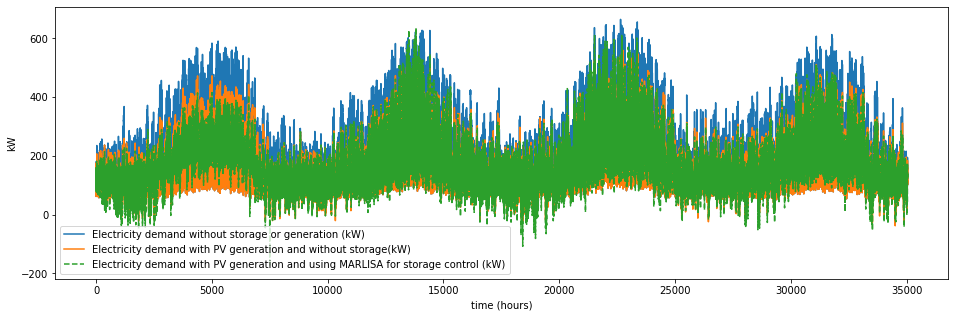

In [ ]:
sim_period = (0, 8760*4 - 1)
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using MARLISA for storage control (kW)'])

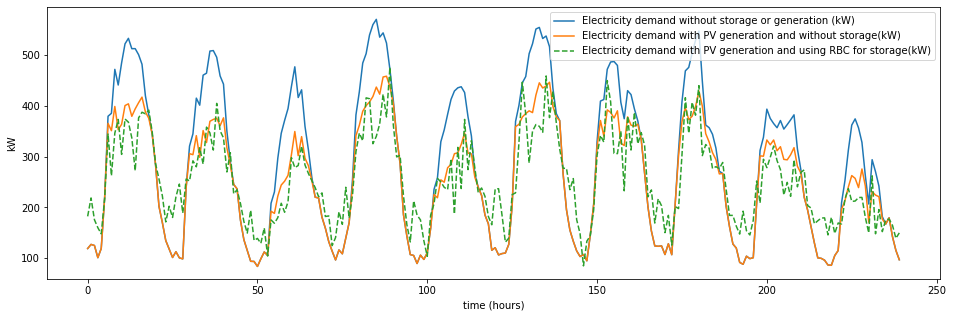

In [ ]:
# Plotting summer operation in the last year
interval = range(8760*3 + 24*30*6, 8760*3 + 24*30*6 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using RBC for storage(kW)'])

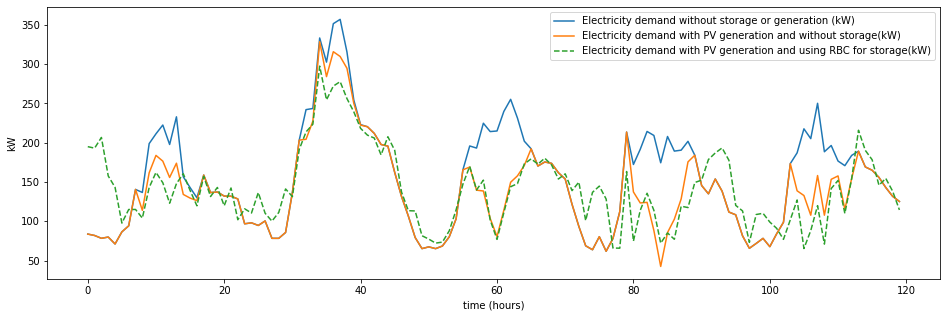

In [ ]:
# Plotting 5 days of winter operation of the last year
plt.figure(figsize=(16,5))
interval = range(8760*3, 8760*3 + 24*5)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using RBC for storage(kW)'])